In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
pwd

'/home/wsuser/work'

In [3]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='IHG1Zqlb1eQ1-AqnXm8JWVb6Wt16HeyJhW1yraHV08qX',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'crudeoilpriceprediction-donotdelete-pr-ocmz552wrfcdur'
object_key = 'Crude Oil Prices Daily.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

data = pd.read_excel(body.read())

data.head()

,Date,Closing Value
0,1986-01-02,25.56
1,1986-01-03,26.00
2,1986-01-06,26.53
3,1986-01-07,25.85
4,1986-01-08,25.87


In [4]:
data.isnull().any()

Date             False
Closing Value     True
dtype: bool

In [5]:
data.isnull().sum()

Date             0
Closing Value    7
dtype: int64

In [6]:
data_oil=data.reset_index()['Closing Value']
data_oil

0       25.56
1       26.00
2       26.53
3       25.85
4       25.87
        ...  
8218    74.19
8219      NaN
8220    73.05
8221    73.78
8222    73.93
Name: Closing Value, Length: 8223, dtype: float64

In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
data_oil=scaler.fit_transform(np.array(data_oil).reshape(-1,1))

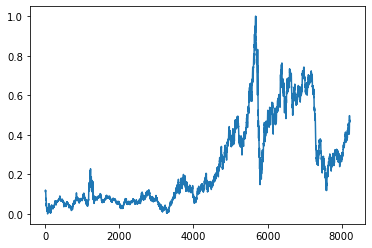

In [8]:
plt.plot(data_oil)

In [9]:
training_size=int(len(data_oil)*0.65)
test_size=len(data_oil)-training_size
train_data,test_data=data_oil[0:training_size,:],data_oil[training_size:len(data_oil),:1]

In [10]:
training_size,test_size

(5344, 2879)

In [11]:
train_data.shape

(5344, 1)

In [12]:
#convert an array of values into a dataset matrix
def create_dataset(dataset,time_step=1):
    dataX,dataY=[], []
    for i in range(len(dataset)-time_step-1):
        a=dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i+time_step,0])
    return np.array(dataX),np.array(dataY)

In [13]:
#reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step=10
x_train,y_train=create_dataset(train_data,time_step)
x_test,ytest=create_dataset(test_data,time_step)

In [14]:
print(x_train.shape),print(y_train.shape)

(5333, 10)
(5333,)


(None, None)

In [15]:
print(x_test.shape),print(ytest.shape)

(2868, 10)
(2868,)


(None, None)

In [16]:
x_train

array([[0.11335703, 0.11661484, 0.12053902, ..., 0.10980305, 0.1089886 ,
        0.11054346],
       [0.11661484, 0.12053902, 0.11550422, ..., 0.1089886 , 0.11054346,
        0.10165852],
       [0.12053902, 0.11550422, 0.1156523 , ..., 0.11054346, 0.10165852,
        0.09906708],
       ...,
       [0.35295424, 0.36376425, 0.35591589, ..., 0.37916482, 0.38153413,
        0.38294092],
       [0.36376425, 0.35591589, 0.36391234, ..., 0.38153413, 0.38294092,
        0.38005331],
       [0.35591589, 0.36391234, 0.37042796, ..., 0.38294092, 0.38005331,
        0.36872501]])

In [17]:
x_train=x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test=x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [18]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [19]:
model=Sequential()

In [20]:
model.add(LSTM(50,return_sequences=True,input_shape=(10,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))

In [21]:
model.add(Dense(1))

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 50)            10400     
                                                                 
 lstm_1 (LSTM)               (None, 10, 50)            20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [23]:
model.compile(loss='mean_squared_error',optimizer='adam')

In [24]:
model.fit(x_train,y_train,validation_data=(x_test,ytest),epochs=50,batch_size=64,verbose=1)

Epoch 1/50
84/84 [==============================] - 7s 37ms/step - loss: 0.0017 - val_loss: nan
Epoch 2/50
84/84 [==============================] - 2s 25ms/step - loss: 1.3310e-04 - val_loss: nan
Epoch 3/50
84/84 [==============================] - 2s 26ms/step - loss: 1.2380e-04 - val_loss: nan
Epoch 4/50
84/84 [==============================] - 2s 25ms/step - loss: 1.2175e-04 - val_loss: nan
Epoch 5/50
84/84 [==============================] - 2s 24ms/step - loss: 1.2370e-04 - val_loss: nan
Epoch 6/50
84/84 [==============================] - 2s 22ms/step - loss: 1.1984e-04 - val_loss: nan
Epoch 7/50
84/84 [==============================] - 2s 22ms/step - loss: 1.2026e-04 - val_loss: nan
Epoch 8/50
84/84 [==============================] - 2s 22ms/step - loss: 1.2191e-04 - val_loss: nan
Epoch 9/50
84/84 [==============================] - 2s 25ms/step - loss: 1.1906e-04 - val_loss: nan
Epoch 10/50
84/84 [==============================] - 2s 25ms/step - loss: 1.1573e-04 - val_loss: nan
Epo

In [25]:
##Transformformback to original form
train_predict=scaler.inverse_transform(train_data)
test_predict=scaler.inverse_transform(test_data)

In [26]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(train_data,train_predict))

29.383753633005615

In [27]:
from tensorflow.keras.models import load_model
model.save("crude_oil.h5")

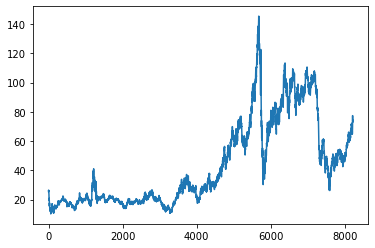

In [28]:
### Plotting
look_back=10
trainpredictPlot = np.empty_like(data_oil)
trainpredictPlot[:, :]= np.nan
trainpredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictplot = np.empty_like(data_oil)
testPredictplot[:,: ] = np.nan
testPredictplot[look_back:len(test_predict)+look_back, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(data_oil))
plt.show()

In [29]:
len(test_data)

2879

In [30]:
x_input=test_data[2865:2875].reshape(1,-1)
x_input.shape

(1, 10)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
temp_input

[0.41218717606989486,
 0.4104101880645639,
 0.4351399378054198,
 0.44172960165852215,
 0.48111950244335855,
 0.49726047682511476,
 0.4679401747371539,
 0.4729749740855915,
 0.47119798608026064,
 0.47341922108692425]

In [33]:
lst_output=[]
n_steps=10
i=0
while(i<10):
    if(len(temp_input)>10):
        #print(temp_input)
        x_input=np.array(temp_input[1:]) 
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1)) #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:] #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist()) 
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

[0.47139308]
11
1 day input [0.41041019 0.43513994 0.4417296  0.4811195  0.49726048 0.46794017
 0.47297497 0.47119799 0.47341922 0.47139308]
1 day output [[0.47095317]]
2 day input [0.43513994 0.4417296  0.4811195  0.49726048 0.46794017 0.47297497
 0.47119799 0.47341922 0.47139308 0.47095317]
2 day output [[0.47162187]]
3 day input [0.4417296  0.4811195  0.49726048 0.46794017 0.47297497 0.47119799
 0.47341922 0.47139308 0.47095317 0.47162187]
3 day output [[0.47290388]]
4 day input [0.4811195  0.49726048 0.46794017 0.47297497 0.47119799 0.47341922
 0.47139308 0.47095317 0.47162187 0.47290388]
4 day output [[0.47467452]]
5 day input [0.49726048 0.46794017 0.47297497 0.47119799 0.47341922 0.47139308
 0.47095317 0.47162187 0.47290388 0.47467452]
5 day output [[0.47638613]]
6 day input [0.46794017 0.47297497 0.47119799 0.47341922 0.47139308 0.47095317
 0.47162187 0.47290388 0.47467452 0.47638613]
6 day output [[0.47774425]]
7 day input [0.47297497 0.47119799 0.47341922 0.47139308 0.4709531

In [34]:
day_new=np.arange(1,11)
day_pred=np.arange(11,21)

In [35]:
len(data_oil)

8223

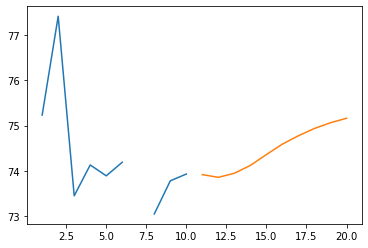

In [36]:
plt.plot(day_new,scaler.inverse_transform(data_oil[8213:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

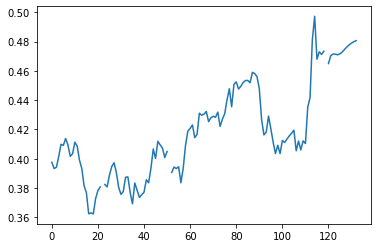

In [37]:
df3=data_oil.tolist()
df3.extend(lst_output)
plt.plot(df3[8100:])

In [38]:
df3=scaler.inverse_transform(df3).tolist()

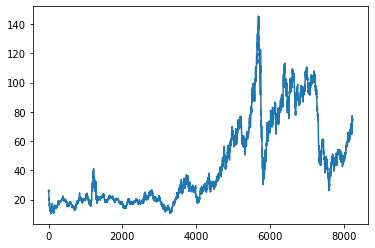

In [39]:
plt.plot(df3)

In [40]:
!pip install ibm_watson_machine_learning


In [41]:
from ibm_watson_machine_learning import APIClient
wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey":"BS2SMFqDeLGEOOnI70kz_nIZbW3T3Zpz3ZxLJUdmoQU1"
    
}
client=APIClient(wml_credentials)

In [42]:
def guid_from_space_name(client,space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item ['entity']["name"]==space_name)['metadata']['id'])

In [43]:
space_uid= guid_from_space_name(client,'models')
print("Space UID = "+space_uid)

Space UID = 89ad4fd9-8a6f-4954-b3e6-427e4f8c4917


In [44]:
client.set.default_space(space_uid)

'SUCCESS'

In [45]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [46]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
software_spec_uid

'12b83a17-24d8-5082-900f-0ab31fbfd3cb'

In [47]:
model_details = client.repository.store_model(model=scaler,meta_props={
client.repository.ModelMetaNames.NAME:"Crude_oil_price_prediction",
client.repository.ModelMetaNames.TYPE:"scikit-learn_1.0",
client.repository.ModelMetaNames.SOFTWARE_SPEC_UID:software_spec_uid }
                                             )
                                              
model_id=client.repository.get_model_id(model_details)

In [48]:
model_id

'6ee04a77-8c98-4e02-92f4-00578c075dbc'

In [49]:
x_train[0]

array([[0.11335703],
       [0.11661484],
       [0.12053902],
       [0.11550422],
       [0.1156523 ],
       [0.11683696],
       [0.1140234 ],
       [0.10980305],
       [0.1089886 ],
       [0.11054346]])